In [1]:
from preprocessing import extract_events, create_raw, create_epochs
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import mne
from scipy.stats import ttest_ind, ttest_ind_from_stats
import matplotlib.gridspec as gridspec
from string import ascii_letters
import seaborn as sns
import copy

In [2]:
# List of dataframes
recordings = [pd.read_pickle(f) for f in os.listdir('.') if f.endswith('.pkl')]
epochs = [create_epochs(recording) for recording in recordings[1:]]
epochs = [mne.concatenate_epochs(epochs[:3]), epochs[3], epochs[4]]

# settings
event_id = dict(call=1, no_call=2, not_bluffing=3, bluffing=4)
tmin, tmax = -4, 4

In [3]:
def reshapeEpochs(epochs, tmax, tmin):
    #Remove empty dimension and average across trials. Returns dictionary
    data={}
    epochs.drop_channels(ch_names = ['theta', 'delta', 'attention', 'meditation'])
    epochs.reorder_channels(ch_names=['lowAlpha', 'highAlpha', 'lowBeta', 'highBeta', 'lowGamma', 'midGamma'])
    for i, ch_name in enumerate(epochs.ch_names):
        r=epochs['bluffing'].copy().pick_channels(ch_names=[ch_name])._data
        bluff_copy=copy.deepcopy(r).T
        bluff=[]
        r=epochs['not_bluffing'].copy().pick_channels(ch_names=[ch_name])._data
        nbluff_copy=copy.deepcopy(r).T
        nbluff=[]
        for trial in bluff_copy:
            bluff.append(np.mean(trial[0]))
        for trial in nbluff_copy:
            nbluff.append(np.mean(trial[0]))
        data[ch_name]={'bluffing':((np.arange(len(bluff))/10)-tmax, np.array(bluff)), 
                       'not_bluffing':((np.arange(len(nbluff))*10)-tmax, np.array(nbluff))}
    return data

In [4]:
 def getDifferences(epochs):
    #Take send dictionary formatted - data[ch_name][bluffing/not_bluffing][0/1(x/y)]
    differences={}
    time=epochs['highAlpha']['bluffing'][0]
    #step through the key names, eg attention, delta, highAlpha...
    for key, value in epochs.items():
        #Get an array of differences between bluffing and not bluffing
        difference=value['bluffing'][1]-value['not_bluffing'][1]
        #The data is saved in this dictionary for future use eg data['attention']
        differences[key]=difference
    return differences, time  

In [5]:
def plotDifferences(epochs, vmin, vmax):
    differences, time=getDifferences(epochs)
    time = np.linspace(-4,4,num=10)
    #step through the channel names, eg attention, delta, highAlpha...
    sns.set(style="white")
    keys=list(differences.keys())
    values=list(differences.values())
    df=pd.DataFrame({'features':keys, 'values':values})#, 'time(s)':time, 'values':values})
    # Draw the heatmap
    f, ax = plt.subplots(figsize=(8, 5))
    ax = sns.heatmap(values, cmap='seismic', xticklabels=5, yticklabels=epochs.keys(), 
                     vmin=vmin, vmax=vmax)#, fmt="g", cmap='viridis')
    ax.set_xlabel('Samples (10 samples/second)')

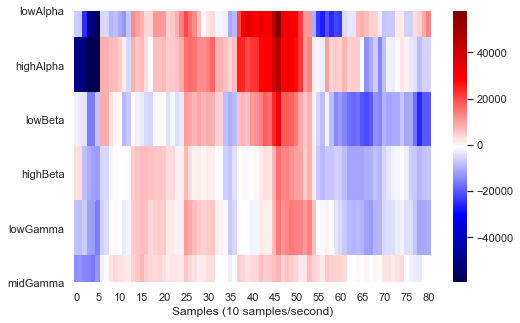

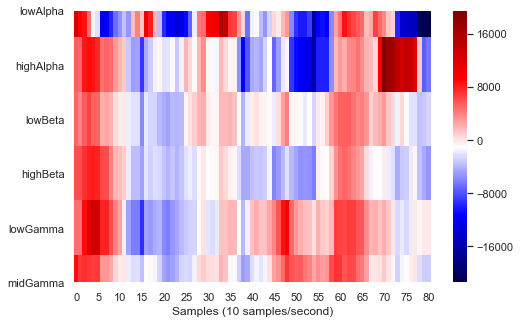

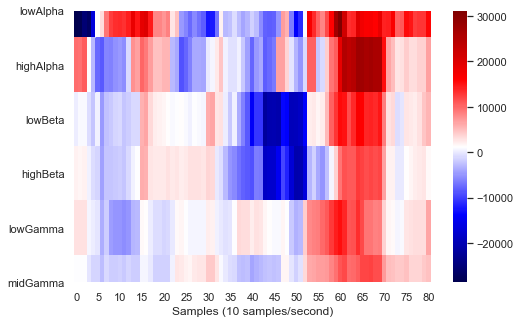

In [7]:
for ind, epoch in enumerate(epochs):
    plotDifferences(reshapeEpochs(epoch, tmax, tmin), vmin=None, vmax = None)
    plt.savefig(f'./htmap_subject{ind}.png', dpi=300)